In [6]:
!pip -q install yfinance statsmodels

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt

In [8]:
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

In [9]:
START = "2013-01-01"
END   = "2025-08-01"

In [10]:
RF_ANNUAL = 0.02
RF_DAILY  = RF_ANNUAL / 252

In [11]:
USE_COMMON_SAMPLE = True

reits_us = [
    "AMT",   # American Tower (tower REIT)
    "CCI",   # Crown Castle (tower REIT)
    "EQIX",  # Equinix (data center REIT)
    "DLR",   # Digital Realty Trust (data center REIT)
]

# MLPs: treated as InvIT-equivalents (pipeline / midstream infra)
mlps_us = [
    "EPD",   # Enterprise Products Partners
    "ET",    # Energy Transfer
    "MPLX",  # MPLX LP
]

# Infra / utilities / listed infrastructure stocks
stocks_us = [
    "BIP",   # Brookfield Infrastructure Partners
    "NEE",   # NextEra Energy
    "DUK",   # Duke Energy
]

# Benchmarks / ETFs
indices_us = [
    "IFRA",  # iShares U.S. Infrastructure ETF
    "PAVE",  # Global X U.S. Infrastructure Dev ETF
    "SPY",   # S&P 500 ETF (broad market)
]

In [12]:
MARKET_US = "IFRA"  # main market proxy for CAPM

In [13]:
tickers = sorted(set(reits_us + mlps_us + stocks_us + indices_us))
print("US tickers:", tickers)

US tickers: ['AMT', 'BIP', 'CCI', 'DLR', 'DUK', 'EPD', 'EQIX', 'ET', 'IFRA', 'MPLX', 'NEE', 'PAVE', 'SPY']


In [14]:
instrument_type = {}

for t in mlps_us:
    instrument_type[t] = "MLPS"

for t in reits_us:
    instrument_type[t] = "REIT"

for t in stocks_us:
    instrument_type[t] = "Stock"

for t in indices_us:
    instrument_type[t] = "Index"

instrument_meta = {
    # REITs
    "AMT":  {"Name": "American Tower", "Sector": "Tower REIT"},
    "CCI":  {"Name": "Crown Castle", "Sector": "Tower REIT"},
    "EQIX": {"Name": "Equinix", "Sector": "Data Center REIT"},
    "DLR":  {"Name": "Digital Realty Trust", "Sector": "Data Center REIT"},

    # MLPs (InvIT-equivalents)
    "EPD":  {"Name": "Enterprise Products Partners", "Sector": "Midstream MLP"},
    "ET":   {"Name": "Energy Transfer", "Sector": "Midstream MLP"},
    "MPLX": {"Name": "MPLX LP", "Sector": "Midstream MLP"},

    # Stocks
    "BIP":  {"Name": "Brookfield Infrastructure Partners", "Sector": "Listed Infrastructure"},
    "NEE":  {"Name": "NextEra Energy", "Sector": "Renewables & Utility"},
    "DUK":  {"Name": "Duke Energy", "Sector": "Electric Utility"},

    # Benchmarks / ETFs
    "IFRA": {"Name": "iShares U.S. Infrastructure ETF", "Sector": "Infra ETF"},
    "PAVE": {"Name": "Global X U.S. Infrastructure Dev ETF", "Sector": "Infra ETF"},
    "SPY":  {"Name": "SPDR S&P 500 ETF", "Sector": "Broad Market"},
}

In [15]:
def download_prices(tickers, start, end):
    df = yf.download(
        tickers, start=start, end=end,
        group_by="column", auto_adjust=False, progress=False
    )
    # Choose Adj Close if present; else Close
    if isinstance(df.columns, pd.MultiIndex):
        top = df.columns.get_level_values(0).unique().tolist()
        field = "Adj Close" if "Adj Close" in top else "Close"
        prices_ = df[field].copy()
    else:
        prices_ = df.copy()

    if isinstance(prices_, pd.Series):
        prices_ = prices_.to_frame()

    # Drop tickers with all NaN
    drop_all_nan = [c for c in prices_.columns if prices_[c].dropna().empty]
    if drop_all_nan:
        print("Dropping tickers with no data:", drop_all_nan)
        prices_ = prices_.drop(columns=drop_all_nan)

    return prices_

In [16]:
def _normalize_dt_index(idx: pd.Index) -> pd.DatetimeIndex:
    # tz-aware → UTC → naive date; tz-naive → just normalize
    idx = pd.to_datetime(idx, utc=True, errors="coerce")
    idx = idx.tz_convert(None).normalize()
    return idx

def total_return_series_from_price_and_dividends(px: pd.Series, div: pd.Series | None) -> pd.Series:
    px = px.dropna().copy()
    px.index = _normalize_dt_index(px.index)

    r_price = px.pct_change().fillna(0.0)

    # dividend return only on ex-dates: cash / previous close
    r_div = pd.Series(0.0, index=px.index)
    if div is not None and not div.empty:
        div = div.copy()
        div.index = _normalize_dt_index(div.index)
        div = div.groupby(div.index).sum()
        aligned_cash = div.reindex(px.index).fillna(0.0)
        r_div = (aligned_cash / px.shift(1)).fillna(0.0)

    tr = (1.0 + r_price + r_div).cumprod()
    return tr

In [17]:
def capm_hac(excess_asset: pd.Series, excess_mkt: pd.Series, hac_lags: int = 5):
    X = sm.add_constant(excess_mkt.values)
    y = excess_asset.values
    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    alpha_d, beta = model.params
    return {
        "Alpha_annual": alpha_d * 252.0,
        "Beta": beta,
        "t_alpha": model.tvalues[0],
        "t_beta":  model.tvalues[1],
        "R2": float(model.rsquared),
        "N_obs": int(model.nobs),
    }

In [18]:
prices = download_prices(tickers, START, END)
print("Price columns:", prices.columns.tolist())

Price columns: ['AMT', 'BIP', 'CCI', 'DLR', 'DUK', 'EPD', 'EQIX', 'ET', 'IFRA', 'MPLX', 'NEE', 'PAVE', 'SPY']


In [19]:
# ensure USE_COMMON_SAMPLE has a default if not defined elsewhere
USE_COMMON_SAMPLE = True

tr_prices = prices.copy()
tickers_tr = [t for t in reits_us if t in prices.columns]

for t in tickers_tr:
    div = yf.Ticker(t).dividends
    tr_prices[t] = total_return_series_from_price_and_dividends(prices[t], div)

# Returns (including market)
tr_returns_raw = tr_prices.pct_change()

if USE_COMMON_SAMPLE:
    cols = [c for c in tr_returns_raw.columns if c in tickers]
    tr_returns = tr_returns_raw[cols].dropna(how="any")
else:
    tr_returns = tr_returns_raw.copy()

print("US returns window:", tr_returns.index.min(), "→", tr_returns.index.max())

US returns window: 2018-04-06 00:00:00 → 2025-07-31 00:00:00


In [20]:
daily_mean = tr_returns.mean()
daily_vol  = tr_returns.std()

annual_ret = daily_mean * 252
annual_vol = daily_vol  * np.sqrt(252)
sharpe     = (annual_ret - RF_ANNUAL) / annual_vol


In [21]:
summary = pd.DataFrame({
    "Annual_Return": annual_ret,
    "Annual_Volatility": annual_vol,
    "Sharpe_Ratio": sharpe
})

In [22]:
summary["Type"]   = summary.index.map(instrument_type.get)
summary["Name"]   = summary.index.map(lambda x: instrument_meta.get(x, {}).get("Name", x))
summary["Sector"] = summary.index.map(lambda x: instrument_meta.get(x, {}).get("Sector", ""))

summary = summary[["Name","Type","Sector","Annual_Return","Annual_Volatility","Sharpe_Ratio"]]
summary

,Name,Type,Sector,Annual_Return,Annual_Volatility,Sharpe_Ratio
Ticker,,,,,,
AMT,American Tower,REIT,Tower REIT,0.1436,0.2803,0.4410
BIP,Brookfield Infrastructure Partners,Stock,Listed Infrastructure,0.1216,0.3057,0.3323
CCI,Crown Castle,REIT,Tower REIT,0.1225,0.2762,0.3709
DLR,Digital Realty Trust,REIT,Data Center REIT,0.1897,0.2981,0.5692
DUK,Duke Energy,Stock,Electric Utility,0.1253,0.2221,0.4742
EPD,Enterprise Products Partners,MLPS,Midstream MLP,0.1430,0.2603,0.4727
EQIX,Equinix,REIT,Data Center REIT,0.1686,0.2902,0.5121
ET,Energy Transfer,MLPS,Midstream MLP,0.1841,0.3602,0.4557
IFRA,iShares U.S. Infrastructure ETF,Index,Infra ETF,0.1378,0.2197,0.5363


In [23]:
if MARKET_US not in tr_returns.columns:
    raise ValueError(f"{MARKET_US} not in tr_returns columns: {tr_returns.columns.tolist()}")

rf_series = pd.Series(RF_DAILY, index=tr_returns.index)

capm_rows = []
for t in tr_returns.columns:
    if t == MARKET_US:
        continue
    df = tr_returns[[t, MARKET_US]].dropna()
    if df.empty:
        continue
    ex_i = df[t] - rf_series.reindex(df.index)
    ex_m = df[MARKET_US] - rf_series.reindex(df.index)
    res = capm_hac(ex_i, ex_m, hac_lags=5)
    res["Ticker"] = t
    capm_rows.append(res)


In [24]:
capm_us = pd.DataFrame(capm_rows).set_index("Ticker")
capm_us = capm_us.join(summary[["Name","Type","Sector"]], how="left")

capm_disp = capm_us.copy()
capm_disp["Alpha_annual"] = (capm_disp["Alpha_annual"]*100).round(2)
capm_disp["Beta"]         = capm_disp["Beta"].round(2)
capm_disp["t_alpha"]      = capm_disp["t_alpha"].round(2)
capm_disp["t_beta"]       = capm_disp["t_beta"].round(2)
capm_disp["R2"]           = capm_disp["R2"].round(2)

capm_disp = capm_disp[["Name","Type","Sector","Alpha_annual","Beta","t_alpha","t_beta","R2","N_obs"]]
print("Market proxy (US):", MARKET_US)
capm_disp

Market proxy (US): IFRA


,Name,Type,Sector,Alpha_annual,Beta,t_alpha,t_beta,R2,N_obs
Ticker,,,,,,,,,
AMT,American Tower,REIT,Tower REIT,5.0600,0.6200,0.5600,9.0900,0.2400,1840
BIP,Brookfield Infrastructure Partners,Stock,Listed Infrastructure,-0.2500,0.8800,-0.0300,11.6400,0.4000,1840
CCI,Crown Castle,REIT,Tower REIT,2.9800,0.6200,0.3500,11.7500,0.2400,1840
DLR,Digital Realty Trust,REIT,Data Center REIT,9.6400,0.6200,1.0000,13.0600,0.2100,1840
DUK,Duke Energy,Stock,Electric Utility,3.3800,0.6100,0.5200,9.0800,0.3600,1840
EPD,Enterprise Products Partners,MLPS,Midstream MLP,3.6600,0.7300,0.4700,10.7200,0.3800,1840
EQIX,Equinix,REIT,Data Center REIT,7.5200,0.6200,0.8500,11.9600,0.2200,1840
ET,Energy Transfer,MLPS,Midstream MLP,5.7000,0.9100,0.5000,10.8100,0.3100,1840
MPLX,MPLX LP,MLPS,Midstream MLP,10.9100,0.7200,1.1100,9.6300,0.2300,1840


In [25]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

summary_out = summary.copy()
summary_out["Region"] = "US"
summary_out.to_csv("summary_us.csv", index_label="Ticker")

capm_out = capm_us.copy()
capm_out["Region"] = "US"
capm_out.to_csv("capm_us.csv", index_label="Ticker")

print("Saved: summary_us.csv, capm_us.csv")

Saved: summary_us.csv, capm_us.csv


In [26]:
# Cell 8: Downside risk metrics for US (Max Drawdown, Sortino, VaR/CVaR)

def max_drawdown(ret: pd.Series) -> float:
    cum = (1 + ret).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0
    return float(dd.min())

def sortino(ret: pd.Series, rf_daily: float | pd.Series) -> float:
    if isinstance(rf_daily, (int, float, np.floating)):
        ex = ret - rf_daily
    else:
        ex = ret - rf_daily.reindex(ret.index)
    downside = np.sqrt((ex[ex < 0] ** 2).mean() * 252)
    ann_ex_ret = ex.mean() * 252
    return float(ann_ex_ret / downside) if downside not in (0, np.nan) else np.nan

def var_cvar(ret: pd.Series, q: float = 0.95) -> tuple[float,float]:
    # Historical VaR/CVaR (loss is positive)
    r = ret.dropna()
    if r.empty:
        return np.nan, np.nan
    cutoff = np.percentile(r, (1 - q) * 100)
    var  = -cutoff
    cvar = -r[r <= cutoff].mean()
    return float(var), float(cvar)

rf_series_const = pd.Series(RF_DAILY, index=tr_returns.index)

risk_rows = []
for t in tr_returns.columns:
    r = tr_returns[t].dropna()
    if r.empty:
        continue
    VaR95, CVaR95 = var_cvar(r, 0.95)
    risk_rows.append({
        "Ticker": t,
        "Max_Drawdown": max_drawdown(r),
        "Sortino": sortino(r, rf_series_const),
        "VaR_95": VaR95,
        "CVaR_95": CVaR95
    })

risk_us = (
    pd.DataFrame(risk_rows)
      .set_index("Ticker")
      .join(summary[["Name","Type","Sector"]], how="left")
      [["Name","Type","Sector","Max_Drawdown","Sortino","VaR_95","CVaR_95"]]
)

risk_us


,Name,Type,Sector,Max_Drawdown,Sortino,VaR_95,CVaR_95
Ticker,,,,,,,
AMT,American Tower,REIT,Tower REIT,-0.4214,0.4433,0.0267,0.0387
BIP,Brookfield Infrastructure Partners,Stock,Listed Infrastructure,-0.5132,0.3339,0.0252,0.0440
CCI,Crown Castle,REIT,Tower REIT,-0.5122,0.3680,0.0263,0.0387
DLR,Digital Realty Trust,REIT,Data Center REIT,-0.4634,0.5602,0.0293,0.0433
DUK,Duke Energy,Stock,Electric Utility,-0.3737,0.4629,0.0196,0.0317
EPD,Enterprise Products Partners,MLPS,Midstream MLP,-0.5804,0.4492,0.0208,0.0369
EQIX,Equinix,REIT,Data Center REIT,-0.4069,0.5125,0.0283,0.0410
ET,Energy Transfer,MLPS,Midstream MLP,-0.7282,0.4377,0.0308,0.0522
IFRA,iShares U.S. Infrastructure ETF,Index,Infra ETF,-0.4106,0.5258,0.0194,0.0322


In [27]:
risk_us_out = risk_us.copy()
risk_us_out["Region"] = "US"
risk_us_out.to_csv("risk_us.csv")
print("Saved: risk_us.csv")


Saved: risk_us.csv


In [28]:
# Cell 9: Correlation matrix for US instruments (total-return basis)
corr_us = tr_returns.corr()
corr_us


Ticker,AMT,BIP,CCI,DLR,DUK,EPD,EQIX,ET,IFRA,MPLX,NEE,PAVE,SPY
Ticker,,,,,,,,,,,,,
AMT,1.0000,0.4125,0.8316,0.5925,0.6056,0.2615,0.6368,0.1587,0.4854,0.1049,0.5650,0.3804,0.4931
BIP,0.4125,1.0000,0.4066,0.4007,0.4538,0.4749,0.4056,0.4019,0.6353,0.3348,0.4415,0.6155,0.6029
CCI,0.8316,0.4066,1.0000,0.6104,0.5905,0.2726,0.6204,0.1683,0.4906,0.1278,0.5405,0.3825,0.4900
DLR,0.5925,0.4007,0.6104,1.0000,0.4355,0.2197,0.7570,0.1917,0.4583,0.1058,0.4340,0.4185,0.5405
DUK,0.6056,0.4538,0.5905,0.4355,1.0000,0.3109,0.4560,0.1905,0.6002,0.1292,0.6897,0.4118,0.4543
EPD,0.2615,0.4749,0.2726,0.2197,0.3109,1.0000,0.2162,0.7442,0.6196,0.7525,0.2866,0.5895,0.5428
EQIX,0.6368,0.4056,0.6204,0.7570,0.4560,0.2162,1.0000,0.1970,0.4718,0.1202,0.4926,0.4242,0.5738
ET,0.1587,0.4019,0.1683,0.1917,0.1905,0.7442,0.1970,1.0000,0.5547,0.7011,0.1674,0.5619,0.5074
IFRA,0.4854,0.6353,0.4906,0.4583,0.6002,0.6196,0.4718,0.5547,1.0000,0.4760,0.5510,0.9160,0.8083


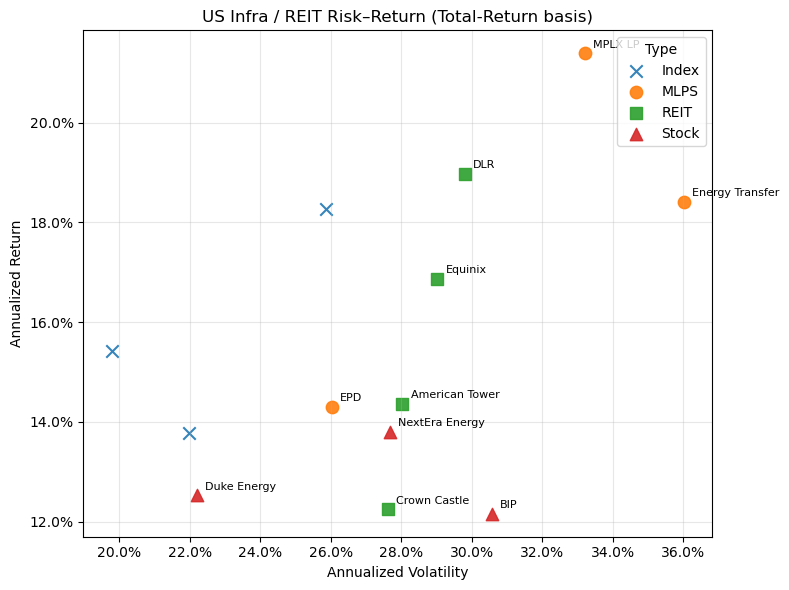

In [29]:
# Cell 10: Risk–Return scatter for US instruments

BASE_RETURNS = tr_returns  # total-return basis

from matplotlib.ticker import PercentFormatter

ann_ret_us = BASE_RETURNS.mean() * 252
ann_vol_us = BASE_RETURNS.std()  * np.sqrt(252)

scatter_us = pd.DataFrame({
    "Annual_Return": ann_ret_us,
    "Annual_Volatility": ann_vol_us,
    "Type": [instrument_type.get(t, "Other") for t in ann_ret_us.index],
    "Name": [instrument_meta.get(t, {}).get("Name", t) for t in ann_ret_us.index]
})

marker_map = {"REIT":"s", "Stock":"^", "Index":"x", "Other":"o"}

plt.figure(figsize=(8,6))
for tp, grp in scatter_us.groupby("Type"):
    plt.scatter(grp["Annual_Volatility"], grp["Annual_Return"],
                marker=marker_map.get(tp, "o"), label=tp, s=80, alpha=0.9)

# Simple labels (only for non-indexes to avoid clutter)
for idx, row in scatter_us[scatter_us["Type"] != "Index"].iterrows():
    label = row["Name"] if len(str(row["Name"])) <= 18 else idx
    plt.annotate(label,
                 (row["Annual_Volatility"], row["Annual_Return"]),
                 textcoords="offset points", xytext=(6,4), fontsize=8)

plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("US Infra / REIT Risk–Return (Total-Return basis)")
plt.grid(True, alpha=0.3)
plt.legend(title="Type")
plt.tight_layout()
plt.show()


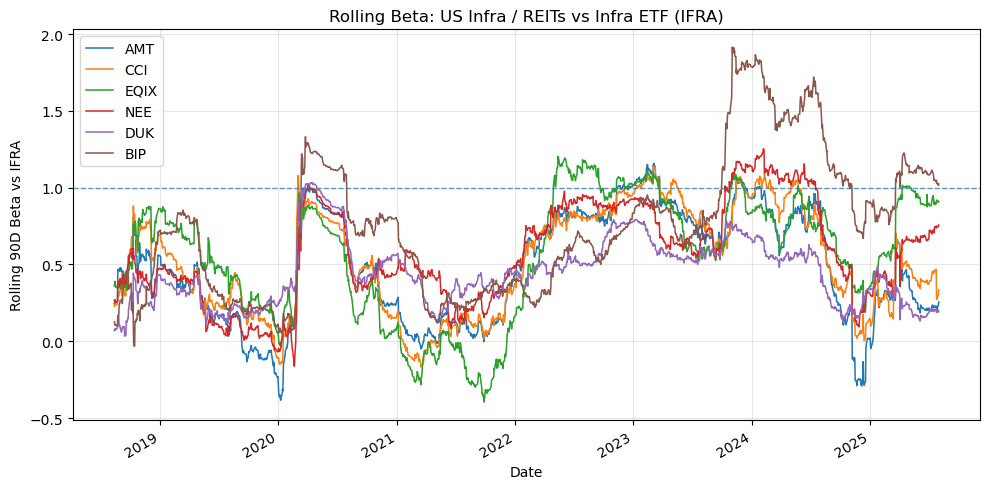

In [30]:
# Cell 11: Rolling 90-day beta vs IFRA

def rolling_beta(ret_df: pd.DataFrame, market_col: str, window: int = 90) -> pd.DataFrame:
    var_m = ret_df[market_col].rolling(window).var()
    betas = {}
    for t in ret_df.columns:
        if t == market_col:
            continue
        cov_im = ret_df[t].rolling(window).cov(ret_df[market_col])
        betas[t] = cov_im / var_m
    return pd.DataFrame(betas)

if MARKET_US not in tr_returns.columns:
    raise ValueError(f"{MARKET_US} not in tr_returns columns: {tr_returns.columns.tolist()}")

rb_us = rolling_beta(tr_returns, MARKET_US, window=90)

# pick a few representative tickers
TICKERS_TO_PLOT = [t for t in ["AMT", "CCI", "EQIX", "NEE", "DUK", "BIP"] if t in rb_us.columns]

plt.figure(figsize=(10,5))
rb_us[TICKERS_TO_PLOT].dropna().plot(ax=plt.gca(), linewidth=1.1)
plt.axhline(1.0, linestyle="--", linewidth=1, alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rolling 90D Beta vs " + MARKET_US)
plt.title("Rolling Beta: US Infra / REITs vs Infra ETF (IFRA)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
# Cell 12: Type-wise summary inside US (extended with median and CAPM averages)

summary_us_type = (
    summary
      .groupby("Type")
      .agg(
          Count=("Annual_Return","count"),
          Ann_Return_mean=("Annual_Return","mean"),
          Ann_Return_median=("Annual_Return","median"),
          Ann_Vol_mean=("Annual_Volatility","mean"),
          Sharpe_mean=("Sharpe_Ratio","mean")
      )
)

# CAPM averages by Type (capm_us includes Alpha_annual, Beta, R2 and was already joined with Type)
capm_by_type = (
    capm_us[["Alpha_annual","Beta","R2","Type"]]
      .groupby("Type")
      .mean()
      .rename(columns={
          "Alpha_annual": "Alpha_avg",
          "Beta": "Beta_avg",
          "R2": "R2_avg"
      })
)

# Join and format for display
summary_us_type = summary_us_type.join(capm_by_type, how="left")

sum_disp = summary_us_type.copy()
sum_disp["Ann. Return (avg) %"]   = (sum_disp["Ann_Return_mean"] * 100).round(2)
sum_disp["Ann. Return (median) %"] = (sum_disp["Ann_Return_median"] * 100).round(2)
sum_disp["Ann. Vol (avg) %"]      = (sum_disp["Ann_Vol_mean"] * 100).round(2)
sum_disp["Sharpe (avg)"]          = sum_disp["Sharpe_mean"].round(2)
sum_disp["Alpha (avg) %"]         = (sum_disp["Alpha_avg"] * 100).round(2)
sum_disp["Beta (avg)"]            = sum_disp["Beta_avg"].round(2)
sum_disp["R² (avg)"]              = sum_disp["R2_avg"].round(2)

# final column order
sum_disp = sum_disp[
    ["Count",
     "Ann. Return (avg) %",
     "Ann. Return (median) %",
     "Ann. Vol (avg) %",
     "Sharpe (avg)",
     "Alpha (avg) %",
     "Beta (avg)",
     "R² (avg)"]
]

sum_disp


,Count,Ann. Return (avg) %,Ann. Return (median) %,Ann. Vol (avg) %,Sharpe (avg),Alpha (avg) %,Beta (avg),R² (avg)
Type,,,,,,,,
Index,3,15.8200,15.4200,22.5500,0.6100,4.2000,0.9000,0.7500
MLPS,3,18.0400,18.4100,31.7600,0.5000,6.7500,0.7900,0.3100
REIT,4,15.6100,15.6100,28.6200,0.4700,6.3000,0.6200,0.2300
Stock,3,12.8300,12.5300,26.8200,0.4100,2.2500,0.7300,0.3600


In [32]:
# Cell 13: Type averages (Total-Return basis) for US (REIT vs Stock)

# We'll work on total-return returns: tr_returns, and summary & capm_us already computed.

types_of_interest = ["MLPS", "REIT", "Stock"]  # InvIT will just drop out if absent

# 1) Type-wise averages from summary (return, vol, Sharpe)
type_metrics_us = (
    summary
      .query("Type in @types_of_interest")
      .groupby("Type")
      .agg(
          Count=("Annual_Return", "count"),
          Ann_Return_mean=("Annual_Return", "mean"),
          Ann_Return_median=("Annual_Return", "median"),
          Ann_Vol_mean=("Annual_Volatility", "mean"),
          Sharpe_mean=("Sharpe_Ratio", "mean")
      )
)

# 2) Type-wise averages from CAPM (Alpha, Beta, R2)
type_capm_us = (
    capm_us
      .query("Type in @types_of_interest")
      .groupby("Type")
      .agg(
          Alpha_mean=("Alpha_annual", "mean"),
          Beta_mean=("Beta", "mean"),
          R2_mean=("R2", "mean")
      )
)

type_summary_us = type_metrics_us.join(type_capm_us, how="left")

# Pretty display in %
ts_us = type_summary_us.copy()
for c in ["Ann_Return_mean", "Ann_Return_median", "Ann_Vol_mean", "Alpha_mean"]:
    ts_us[c] = (ts_us[c] * 100).round(2)

ts_us["Sharpe_mean"] = ts_us["Sharpe_mean"].round(2)
ts_us["Beta_mean"]   = ts_us["Beta_mean"].round(2)
ts_us["R2_mean"]     = ts_us["R2_mean"].round(2)

ts_us.rename(columns={
    "Ann_Return_mean":   "Ann. Return (avg) %",
    "Ann_Return_median": "Ann. Return (median) %",
    "Ann_Vol_mean":      "Ann. Vol (avg) %",
    "Sharpe_mean":       "Sharpe (avg)",
    "Alpha_mean":        "Alpha (avg) %",
    "Beta_mean":         "Beta (avg)",
    "R2_mean":           "R² (avg)"
}, inplace=True)

print("US – Type Averages (Total-Return basis):")
ts_us


US – Type Averages (Total-Return basis):


,Count,Ann. Return (avg) %,Ann. Return (median) %,Ann. Vol (avg) %,Sharpe (avg),Alpha (avg) %,Beta (avg),R² (avg)
Type,,,,,,,,
MLPS,3,18.0400,18.4100,31.7600,0.5000,6.7500,0.7900,0.3100
REIT,4,15.6100,15.6100,28.6200,0.4700,6.3000,0.6200,0.2300
Stock,3,12.8300,12.5300,26.8200,0.4100,2.2500,0.7300,0.3600


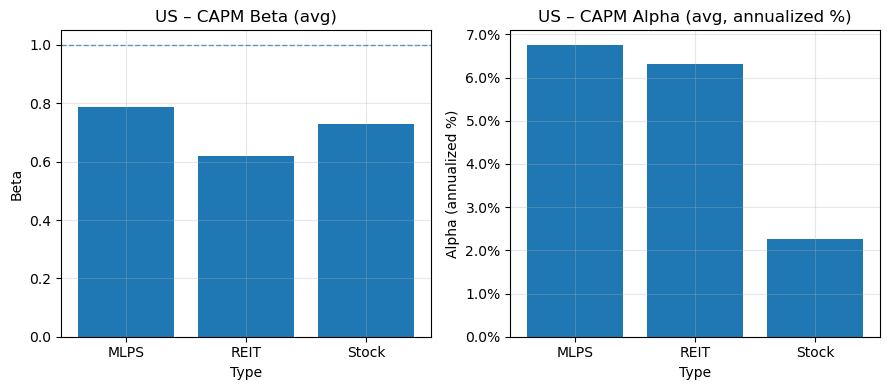

In [33]:
# Cell 14: CAPM Beta (avg) and Alpha (avg, annualized %) – bar charts for US

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Use the type_summary table from Cell 13
ts_plot = type_summary_us.copy()

fig, axes = plt.subplots(1, 2, figsize=(9,4))

# Beta bar
axes[0].bar(ts_plot.index, ts_plot["Beta_mean"])
axes[0].axhline(1.0, linestyle="--", linewidth=1, alpha=0.7)
axes[0].set_title("US – CAPM Beta (avg)")
axes[0].set_xlabel("Type")
axes[0].set_ylabel("Beta")
axes[0].grid(True, alpha=0.3)

# Alpha bar (in %)
alpha_pct = ts_plot["Alpha_mean"] * 100
axes[1].bar(ts_plot.index, alpha_pct)
axes[1].yaxis.set_major_formatter(PercentFormatter(100))
axes[1].set_title("US – CAPM Alpha (avg, annualized %)")
axes[1].set_xlabel("Type")
axes[1].set_ylabel("Alpha (annualized %)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


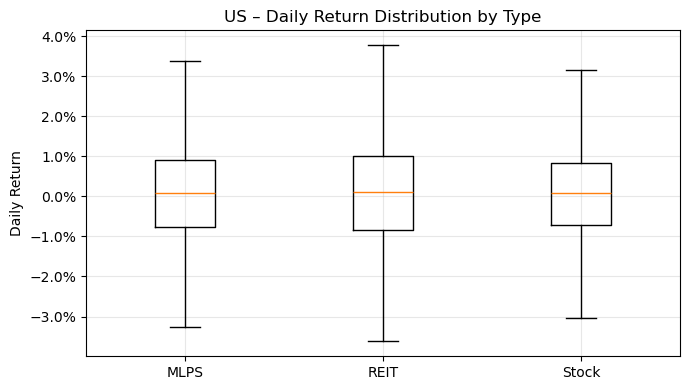

In [34]:
# Cell 15: Daily Return Distribution by Type – boxplot (US)

from matplotlib.ticker import PercentFormatter

# Stack returns by Type from tr_returns
stack_rows = []
for c in tr_returns.columns:
    t_type = instrument_type.get(c, "Other")
    if t_type in ["MLPS", "REIT", "Stock"]:
        df_tmp = pd.DataFrame({
            "Ticker": c,
            "Type": t_type,
            "Ret": tr_returns[c].dropna()
        })
        stack_rows.append(df_tmp)

if stack_rows:
    stack_us = pd.concat(stack_rows, axis=0)

    # Prepare data for each type
    ordered_types = ["MLPS", "REIT", "Stock"]
    data = [stack_us.loc[stack_us["Type"] == t, "Ret"] for t in ordered_types if t in stack_us["Type"].unique()]
    labels = [t for t in ordered_types if t in stack_us["Type"].unique()]

    fig, ax = plt.subplots(figsize=(7,4))
    ax.boxplot(data, labels=labels, showfliers=False)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_title("US – Daily Return Distribution by Type")
    ax.set_ylabel("Daily Return")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No returns available for InvIT/REIT/Stock in US sample.")


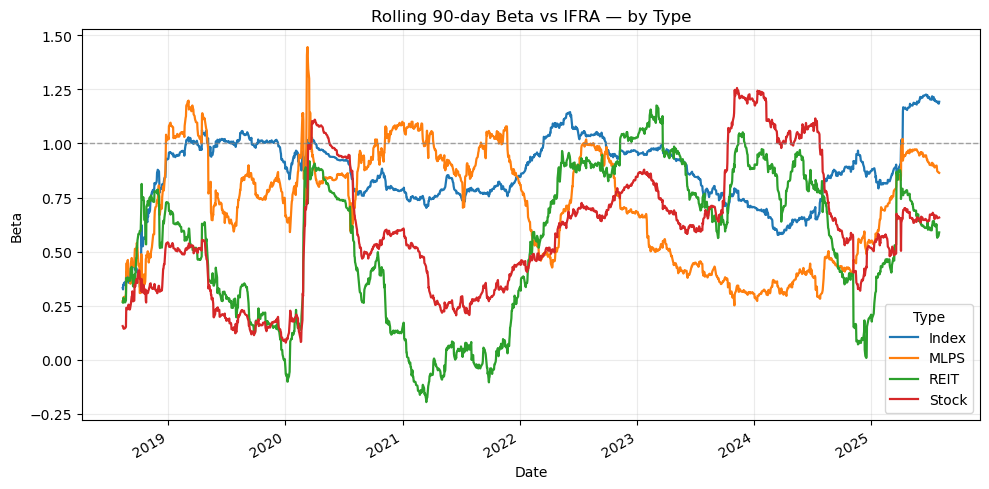

In [35]:
# ...existing code...
# 90-day rolling beta by Type (Index, REIT, Stock) — Python version
window = 90
types_to_plot = ["Index", "MLPS", "REIT", "Stock"]

# map tickers by type, keeping only those present in rb_eu
type_tickers = {
    tp: [t for t, tt in instrument_type.items() if tt == tp and t in rb_us.columns]
    for tp in types_to_plot
}

# build DataFrame with mean rolling beta per type
type_rb = pd.DataFrame(index=rb_us.index)
for tp, cols in type_tickers.items():
    if cols:
        type_rb[tp] = rb_us[cols].mean(axis=1)

# Plot
plt.figure(figsize=(10,5))
ax = plt.gca()
type_rb.dropna(how="all").plot(ax=ax, linewidth=1.6)
ax.axhline(1.0, linestyle="--", color="gray", linewidth=1, alpha=0.7)
ax.set_title(f"Rolling {window}-day Beta vs {MARKET_US} — by Type")
ax.set_xlabel("Date")
ax.set_ylabel("Beta")
ax.grid(True, alpha=0.25)
plt.legend(title="Type")
plt.tight_layout()
plt.show()
# ...existing code...